# Chatbots with Multiple Tools

This notebook demonstrates how to use Arxiv and Wikipedia tools with LangGraph.

In [25]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

# Wrapper
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=100)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

tools = [wiki, arxiv]

In [26]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surpris'

In [27]:
wiki.invoke("What is the capital of France?\n")

'Page: Closed-ended question\nSummary: A closed-ended question is any question for which a researcher '

In [28]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()
tavily.invoke("Provide me the AI news")

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business Growth',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'More\n       About AI News\n       Advertise\n       Contact Us\n\n   News\n   Categories\n       AI and Us\n           Environment & Sustainability\n           Human-AI Relationships\n           Open-Source & Democratised AI\n           Trust, Bias & Fairness\n           World of Work\n\n       AI in Action\n           Creative Industries\n           Cybersecurity AI\n           Education AI\n           Entertainment & Media\n           Finance AI\n           Government & Public Sector AI\n           Healthcare & Wellness AI\n           Legal Industry AI\n           Manufacturing & Engineering AI\n           Marketing AI\n           Utilities\n           Workforce & HR AI\n           Retail & Logistics AI\n           Service Industry AI [...] Explore All\n   Developer\n   IoT News\n   MarketingTech\n   CloudTech\n   Telecoms\n   TechH

In [30]:
tools =[arxiv,wiki,tavily]

In [31]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='openai/gpt-oss-120b')

In [32]:
llm_with_tools=llm.bind_tools(tools)


In [9]:
from langchain.messages import HumanMessage
llm_with_tools.invoke([HumanMessage(content="What is the latest paper on quantum computing?")]).tool_calls


[{'name': 'arxiv',
  'args': {'query': 'quantum computing'},
  'id': 'fc_7a0d2a8b-fd73-4f72-86ac-49f6f6fcf325',
  'type': 'tool_call'}]

In [18]:
#Now using the original langgraph chatbot model that we always make
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import BaseMessage
from typing import TypedDict
from typing_extensions import Annotated
from typing import List

class State(TypedDict):
    messages:Annotated[List[BaseMessage],None]


In [19]:
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools(State["messages"])}


In [20]:
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

In [21]:
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,

)
builder.add_edge("tool_calling_llm", END)

In [22]:
graph=builder.compile()

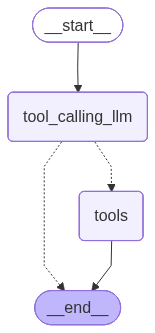

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
from langchain.messages import HumanMessage
messsages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

TypeError: 'RunnableBinding' object is not callable